# Benchmarking of 'pregenerated input' RTC

From the ```dataset-generate.ipynb``` notebook, we have a bunch of files from a simulation for insertion at the input stage and for validation. This notebook will guide you through the benchmarking of the RTC using these files and optionally validating the output.

## Notebook to script

Execute the following to convert it to a script (change it to a code cell first!)

```bash
!jupyter nbconvert --to script benchmarking-rtc-pregen.ipynb
```

However, the script will only run properly when in the ```$SHESHA_ROOT``` folder as a working directory.

In [26]:
import os
import matplotlib.pyplot as plt
from shesha.sutra_wrap import carmaWrap_context
import shesha.util.hdf5_util as h5u
from shesha.util.sys_util import wait_for_idle
import numpy as np

## Constants

We set the constants beforehand

**DEVICES:** The GPU devices being used

**THRESHOLD:** The simulator will wait for idle before running, set what 'idle' is by utilisation %

**NITER:** Number of iterations

**PARAM_FILE:** Path to the parameter file used

**WFS_FILE:** Path to the output WFS file, should be .npz extension

**CENTROIDS_FILE:** Path to the output centroids file, should be .npz extension. Not providing this will turn off centroiding validation.

**VOLTAGES_FILE:** Path to the output voltages file, should be .npz extension. Not providing this will turn off voltages validation.

**RUNTIME_IMAGE:** Path to save the graph of runtime (extension required)

**PROFILE_IMAGE:** Path to save the graph of execution profile (extension required)

In [27]:
def is_jupyter():
    """Check if running in jupyter"""
    try:
        if str(get_ipython()).find("ipykernel") == 1:
            return True
        return False
    except Exception:
        return False
IS_JUPYTER = is_jupyter()

DEVICES = [0]
THRESHOLD_CPU, THRESHOLD_GPU = (30, 5)
PARAM_FILE = os.path.abspath("../data/par/par4bench/scao_sh_16x16_8pix.py")
RUNTIME_IMAGE = None
PROFILE_IMAGE = None
WFS_FILE = os.path.abspath("./wfs.npz")
CENTROIDS_FILE = os.path.abspath("./centroids.npz")
VOLTAGES_FILE = os.path.abspath("./voltages.npz")

if not IS_JUPYTER:
    from argparse import ArgumentParser
    
    parser = ArgumentParser()
    parser.add_argument("file", help="Parameter .py file", type=str)
    parser.add_argument("input_wfs", help="Filename for wfs images .npz file")
    parser.add_argument("-c", "--validation_centroids", default=None, help="Filename for validation centroids .npz file")
    parser.add_argument("-v", "--validation_voltages", default=None, help="Filename for validation voltages .npz file")
    parser.add_argument("-r", "--runtime_image", default=os.path.abspath("./runtime.png"), help="Save runtime plot as an image")
    parser.add_argument("-p", "--profile_image", default=os.path.abspath("./profile.png"), help="Save execution profile graph as an image")
    parser.add_argument("--devices", default=DEVICES, nargs='+', help='A list of GPU devices ex. "0 1 2"', type=int)
    parser.add_argument("--threshold_cpu", default=THRESHOLD_CPU, help="Wait for CPU utilisation to drop below specified amount in percent", type=float)
    parser.add_argument("--threshold_gpu", default=THRESHOLD_GPU, help="Wait for GPU utilisation to drop below specified amount in percent", type=float)

    args = parser.parse_args()

    DEVICES = args.devices
    THRESHOLD_CPU, THRESHOLD_GPU = (args.threshold_cpu, args.threshold_gpu)
    PARAM_FILE = os.path.abspath(args.file)
    RUNTIME_IMAGE = os.path.abspath(args.runtime_image)
    PROFILE_IMAGE = os.path.abspath(args.profile_image)
    WFS_FILE = os.path.abspath(args.output_wfs)
    CENTROIDS_FILE = os.path.abspath(args.output_centroids) if args.output_centroids is not None else None
    VOLTAGES_FILE = os.path.abspath(args.output_voltages) if args.output_voltages is not None else None

## Timer Setup

We setup our timing wrapper using the high precision timer in ```timeit```. This wrapper will add times to a specified array.

In [28]:
from timeit import default_timer as get_time

def timer_wrap_function(times, function):
    """
    Returns the function wrapped in another function. The inner function will be timed, 
    and times will be added to a specified array
    """
    
    def wrapper(*args, **kwargs):        
        start_time = get_time()
        res = function(*args, **kwargs)
        end_time = get_time()
        times.append(end_time - start_time)
        return res
    return wrapper

## Simulation Setup

This section sets up the simulation based on the parameter file given. We will also inject our timing wrappers here. Addionally, we load the files needed for input and validation.

In [29]:
from shesha.supervisor.compassSupervisor import CompassSupervisor as Supervisor

wfs_file = np.load(WFS_FILE)
centroids_file = np.load(CENTROIDS_FILE) if CENTROIDS_FILE is not None else None
voltages_file = np.load(VOLTAGES_FILE) if VOLTAGES_FILE is not None else None

NITER = len(wfs_file)
if centroids_file is not None and len(centroids_file) != NITER or voltages_file is not None and len(voltages_file) != NITER:
    raise Exception("Length of wfs file does not match provided lengths of centroid or voltages files")

supervisor = Supervisor(PARAM_FILE)
supervisor.config.p_loop.set_devices(DEVICES)
supervisor.initConfig()
simulator = supervisor._sim

  0%|          | 0/1 [00:00<?, ?it/s]

loading: scao_sh_16x16_8pix
->tel
*-----------------------
Computing geometry of WFS 0
r0 for WFS : 0.16  m
seeing for WFS :  0.64 "
quantum pixsize :  0.0580 "
simulated FoV :  3.71 " x  3.71 "
actual pixsize :  0.2901
actual FoV :  2.32 " x  2.32 "
number of phase points :  18
size of fft support :  64
size of HR spot support :  64
pupdiam used:  288
Generic pupil created
nphotons :  1577393.3612004826
->atmos
Creating turbulent layers :


100%|██████████| 284/284 [00:00<00:00, 2985.11it/s]


->dm
Pattern type : square
Computing Influence Function type :  default


DM1: 100%|██████████| 2/2 [00:00<00:00, 3335.43it/s]

->target
->wfs
->rtc
Doing imat geom...
Filtering unseen actuators... 
Done
CONTROLLER ADDED
done in 0.266743 s


Doing imat svd...
svd done in 0.011552 s
Building cmat...
Filtering  4  modes
cmat done in 0.000315 s


In [30]:
loop_times = []

count_rtc = len(simulator.rtc.d_control)
count_wfs = len(simulator.wfs.d_wfs)

output_centroids = []
output_voltages = []

def rtc_loop(input_wfs):
    """ Takes input wfs images and runs it through the pipeline.
        Outputs the resulting centroids and voltages to the specified array
    """
    for n in range(count_wfs):
        simulator.wfs.d_wfs[n].set_binimg(input_wfs[n], input_wfs[n].size)
    for n in range(count_rtc):
        simulator.doCentroids(n)
        simulator.doControl(n)
        simulator.doClipping(n)
        simulator.applyControl(n)
    output_centroids.append(np.array([supervisor.getCentroids(j) for j in range(len(simulator.rtc.d_control))]))
    output_voltages.append(np.array([supervisor.getVoltage(j) for j in range(len(simulator.rtc.d_control))]))
        
timed_rtc_loop = timer_wrap_function(loop_times, rtc_loop)

## RTC Loop

With this loop we:

* start timing
* copy one image into the proper array in GPU to be used by the first RTC routine (centroiding)
* execute the RTC pipeline
* copy the result in an array of output (for possible checks)
* stop timing
* move to next image in the sequence

In [31]:
wait_for_idle(THRESHOLD_CPU, THRESHOLD_GPU, DEVICES)

for i in range(NITER):
    wfs_arr = wfs_file[str(i)]
    timed_rtc_loop(wfs_arr)
    
print("Iterations done.")

Waiting until CPU and GPU idle.... (< 30% CPU < 5% GPU)
CPU at 4.1% and GPU at 0.0%
Wait is over, let's go
Iterations done.


## Perform validation

If validation files have been provided, validation will run next. This simply consists of array comparisons.

In [34]:
if centroids_file is not None:
    print("Centroids file provided, validating centroids output...")
    valid_centroids = []
    is_centroids_valid = True
    for i in range(NITER):
        try:
            tmp = [np.array_equal(output_centroids[i][j], centroids_file[str(i)][j]) for j in range(count_rtc)]
            valid_centroids.append(tmp)
            
            for j, res in enumerate(tmp):
                if not res:
                    print("Validation failed on comparing centroid record {}, controller {}.".format(i, j))
                    is_centroids_valid = False
        except Exception:
            valid_centroids.append([False for j in range(count_rtc)])
            print("Exception occured when comparing centroid record {}, controller {}.".format(i, j))
            is_centroids_valid = False
    print("Centroids validation completed with {} errors.".format("no" if is_centroids_valid else "some"))

if voltages_file is not None:
    print("Voltages file provided, validation voltages output...")
    valid_voltages = []
    is_voltages_valid = True
    for i in range(NITER):
        try:
            tmp = [np.array_equal(output_voltages[i][j], voltages_file[str(i)][j]) for j in range(count_rtc)]
            valid_voltages.append(tmp)
            
            for j, res in enumerate(tmp):
                if not res:
                    print("Validation failed on comparing voltage record {}, controller {}.".format(i, j))
                    is_voltages_valid = False
        except Exception:
            valid_voltages.append([False for j in range(count_rtc)])
            print("Exception occured when comparing voltage record {}, controller {}.".format(i, j))
            is_voltages_valid = False
    print("Voltages validation completed with {} errors.".format("no" if is_centroids_valid else "some"))

Centroids file provided, validating centroids output...
Centroids validation completed with no errors.
Voltages file provided, validation voltages output...
Voltages validation completed with no errors.


## Plotting the results

We create the data plots to see the distribution of runtimes. This allows us to see if there is jitter within the control loop, and what sort of jitter it is. Additionally we have the execution profile as a histogram, to see the range of execution times and their frequency.

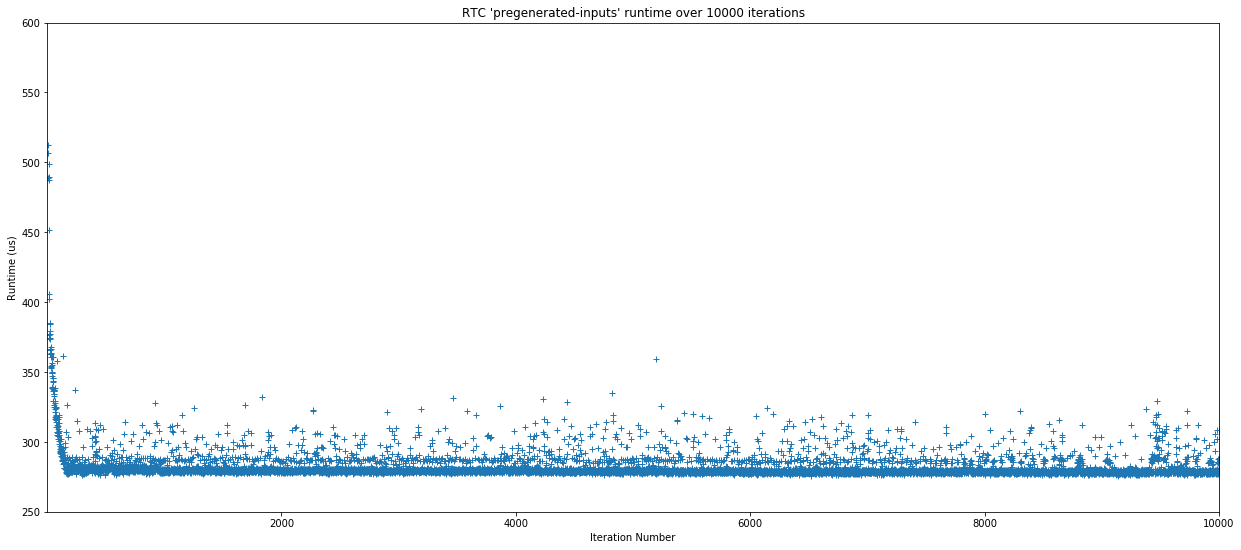

In [35]:
fig = plt.figure(figsize=(21,9))
ax = fig.add_subplot(1, 1, 1)
ax.plot([i for i in range(1, NITER + 1)], [n * 1e6 for n in loop_times], '+')
ax.set_xlim(1, NITER)
ax.set_ylim(250, 600)
ax.set_title("RTC 'pregenerated-inputs' runtime over {} iterations".format(NITER))
ax.set_xlabel("Iteration Number")
ax.set_ylabel("Runtime (us)")
fig.show()
if RUNTIME_IMAGE is not None:
    fig.savefig(RUNTIME_IMAGE)

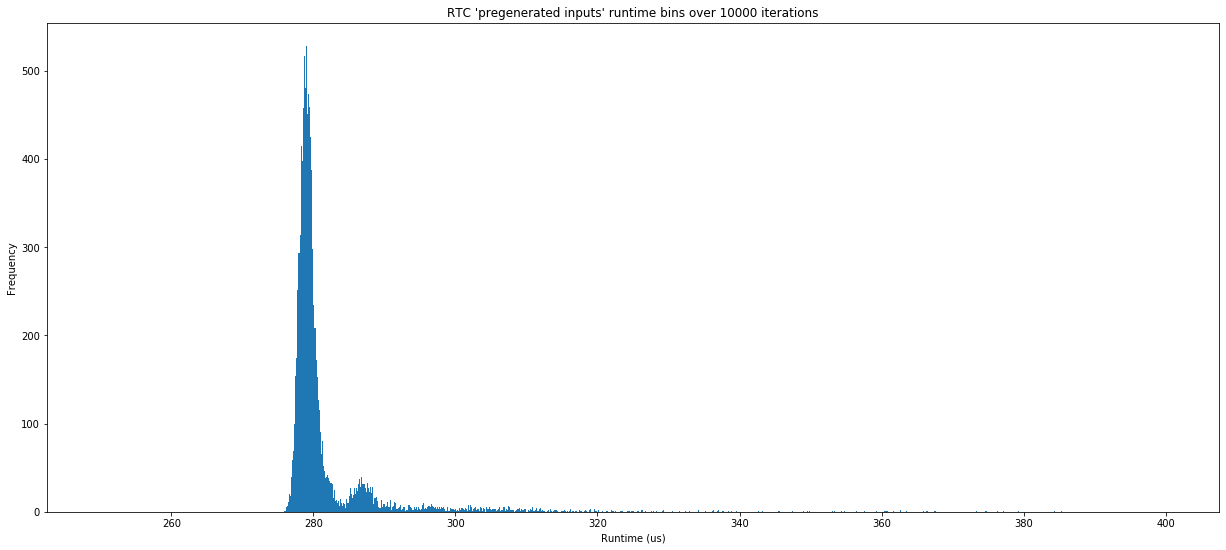

In [36]:
fig = plt.figure(figsize=(21,9))
ax = fig.add_subplot(1, 1, 1)
ax.hist([n * 1e6 for n in loop_times], bins = 1000, range=(250,400))
ax.set_title("RTC 'pregenerated inputs' runtime bins over {} iterations".format(NITER))
ax.set_xlabel("Runtime (us)")
ax.set_ylabel("Frequency")
fig.show()
if PROFILE_IMAGE is not None:
    fig.savefig(PROFILE_IMAGE)